<a href="https://colab.research.google.com/github/constantbourdrez/DL_ESPCI/blob/main/ADL_GAN_Sheep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# Torch numpy and co
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
#
import _pickle as cPickle
import  gzip
from tqdm import tqdm

# Generative Adversarial Networks (GANs)

GAN is a framework to learn efficient generative model. The idea is to learn the data  distribution, and then to be able to generate or sample from this distribution. The seminal paper [was published in 2014](https://arxiv.org/abs/1406.2661). Afterwards a lot of development has been achieved to improve and extend this approach. GANs can be very powerful as generative models. However, it is worth noticing that **training GANs is somewhat of an art form**:  incorrect architectures and hyperparameter settings lead to poor results and unstable training. For instance, we can borrow some recipes from papers and [this best practices](https://github.com/soumith/ganhacks).


**The goal  of this session:** is to implement a GAN setup to generate small images (28,28).


## Overview
GAN considers two models (i.e two neural networks): a generator and a discriminator.
- **the generator** tries to generate images that look  like the training images.
- **the discriminator** is a binary classifier trained to distinguish real images from artificially generated ones.

Both the discriminator and the generator are trained jointly but with different goals:
- the discriminator to separate real images from the ones generated by the generator and
- the generator to fool the discriminator.

The expected equilibrium of this game is when the generator is generating perfect fakes that look as if they came directly from the training data, and the discriminator is left to always guess at 50% confidence that the generator output is real or fake.


Assume $x$ is an image, $D(x)$  is the discriminator network which outputs the (scalar) probability that $x$ is a real image picked from training data rather that a fake one. Here we consider monochrome images, so a Tensor of size $(1,28,28)$.
For the generator, the input is a random vector sampled from a standard normal distribution. The generator transforms this noise $z$  in an image $G(z)$ a map from the latent vector $z$ to data-space.

Therefore, $D(G(z))$ is the probability that the output of the generator $G$ looks like a real image. $D$ and $G$ play a minimax game in which $D$ tries to maximize the probability of classification for real and fake images, while  $G$ tries to minimize the probability that $D$ will predict its outputs as fake.

**TODO**:
- Write the minimax optimization problem, assuming that real images (the training data) are sampled from the data distribution $P_d$, while the noise is sampled from a normal distribution $P_n$.  
- Propose a practical method to optimize both the discriminator and the generator. In practice, we will use the BCELoss as a starting point. Write the training algorithm using this loss.


## DCGAN
DCGAN stands for Deep Convolutional GAN ([see this seminal paper for more details](https://arxiv.org/pdf/1511.06434.pdf)). In this session, we will implement a light version of DCGAN.

# The data set

We could use MNIST, but we prefer to use a dataset made of human drawings:
the Quick draw dataset contains about 50.000.000 drawings, made by real people....
In this lab session we will focus our effort on sheep drawing. **Get the *sheep.npy*** dataset. It only contains sheep drawings.


Remark:
- To get the full dataset : https://github.com/googlecreativelab/quickdraw-datasetDatasets
- in numpy bitmap file : https://console.cloud.google.com/storage/quickdraw_dataset/full/numpy_bitmap
- And more specifically the sheep part: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sheep.npy


# Helper functions

We provide two very simple function that you can modify: the first one to plot data, and the other one to generate random samples to feed the generator.  

In [4]:
def plotdata(t):
    plt.imshow(t.squeeze(),cmap='Greys' )
    plt.colorbar()

In [5]:
def random_noise_generator(batch_size, dim):
    return th.rand(batch_size, dim)*2 - 1

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
folder_path = 'drive/MyDrive/DL/'

# Dataset
Now look at the data.  

In [8]:
data = np.load(f"{folder_path}sheep.npy")
print("Shape of data", data.shape)
print("Grey Scale", data.min(), data.max())
data = data[:20000]

Shape of data (126121, 784)
Grey Scale 0 255


In [9]:
data = data / data.max()
data = data.reshape(-1,1,28,28)
print(data.shape)

(20000, 1, 28, 28)


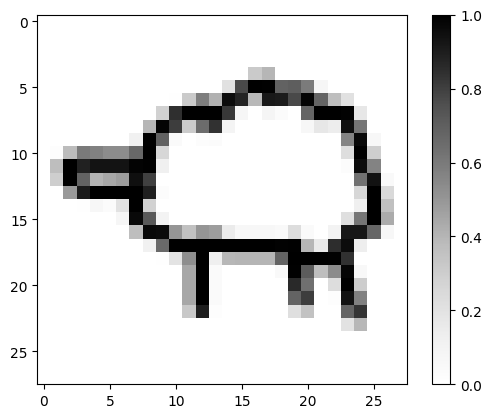

In [10]:
i = 2220
plotdata(data[i])


To create your own dataloader you can do that:

In [14]:
BatchSize = 100
# create your datset
# dataset = TensorDataset(x_tensor, y_tensor)
# Here we don't have labels but only images.
data = th.Tensor(data)
dataset = TensorDataset(th.Tensor(data))
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader instances for training and test sets
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

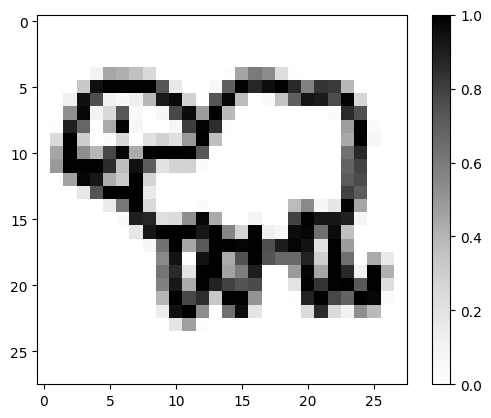

In [15]:
plotdata(data[i+1])

# Models for Discriminator and Generator

For the implementation of the Discriminator and the Generator, we will use two different of convolutional networks.
For the discriminator, the goal is to build a binary classifier. We can therefore make a cascade of (Conv2d, BatchNorm2d, Relu), for instance twice.

**TODO:** Build the discriminator and test it.


In [92]:
device='cpu'
if th.cuda.is_available():
    device='cuda'

In [162]:
class Discriminator(nn.Module):
  def __init__(self, och = 16):
    super(Discriminator, self).__init__()
    # Define layers for the discriminator
    self.conv1 = nn.Conv2d(1, och, kernel_size=3, stride = 2, padding = 1)
    self.batchnorm1 = nn.BatchNorm2d(och)
    self.relu1 = nn.ReLU()
    self.conv2= nn.Conv2d(och, 2*och, kernel_size=3)
    self.batchnorm2 = nn.BatchNorm2d(2*och)
    self.relu2 = nn.ReLU()
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(2*och*12*12, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = self.relu1(x)
    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = self.relu2(x)
    x = self.flatten(x)
    x = self.fc(x)
    x = self.sigmoid(x)
    return x

discriminator = Discriminator().to(device)
output = discriminator(data[2].to(device).unsqueeze(0))
print(output)

tensor([[0.5435]], device='cuda:0', grad_fn=<SigmoidBackward0>)


For the generator, the problem is a bit different. The input is a random vector and the output is an image. To some extent, it is the reverse of the discriminator.
A way to achieve that is to decompose the transformation:  
- A first linear layer that transforms  the random vector of size 100 into a larger vector of size (7x7xoch), with *och*  is the number of "output channels"
- Unflat the vector to an image of size (och,7,7)
- Then we can apply the reverse of a convolution to expand the dimensions of width and heights, and reducing the number of channels. This operation is called ConvTranspose2d. Look at the documentation carefully.  
- The final activation can be a sigmoid since the pixel values are between 0 and 1.

**TODO:** code the generator and test it with the random generator.

In [163]:
class Generator(nn.Module):
  def __init__(self, och = 128):
    super(Generator, self).__init__()
    self.linear1 = nn.Linear(100, och*7*7)
    self.unflatten = nn.Unflatten(1, (och,7,7))
    self.reverseconvolution1 = nn.ConvTranspose2d(och, och//2, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    self.relu1 = nn.ReLU()
    self.reverseconvolution2 = nn.ConvTranspose2d(och//2, och//4, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    self.relu2 = nn.ReLU()
    self.reverseconvolution3 = nn.ConvTranspose2d(och//4, 1, kernel_size = 3, stride = 1, padding = 1)
    self.sigmoid = nn.Sigmoid()
  def forward(self, x):
    x = self.linear1(x)
    x = self.unflatten(x)
    x = self.reverseconvolution1(x)
    x = self.relu1(x)
    x = self.reverseconvolution2(x)
    x = self.relu2(x)
    x = self.reverseconvolution3(x)
    x = self.sigmoid(x)
    return x

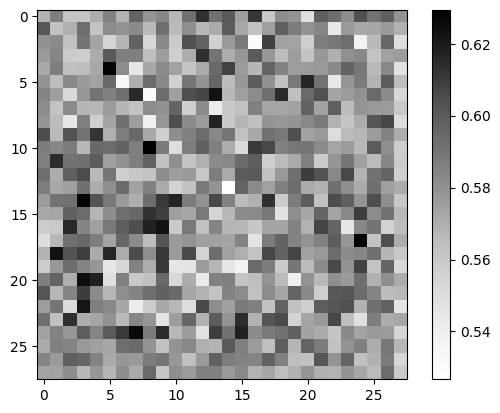

In [95]:
generator = Generator().to(device)
output = generator(random_noise_generator(1, 100).to(device))
plotdata(output.cpu().detach())

# The loss function

For a GAN the loss is the sum of two terms as described above. To implement this peculiar loss, we can use the BCELoss already implemented in pytorch as a building block.

**TODO:**
- Propose two functions for the two terms of the GAN loss
- Test them on some examples that use the Generator and the Discriminator.



In [142]:
real_batch_labels = th.ones(BatchSize, 1)
fake_batch_labels = th.zeros(BatchSize, 1)
criterion = nn.BCELoss()

def generator_loss(fake_output, real_batch_labels, criterion):
  loss = criterion(fake_output, real_batch_labels)
  return loss

def discriminator_loss(real_output, fake_output, real_labels, fake_labels, criterion):
    real_loss = criterion(real_output, real_labels)
    fake_loss = criterion(fake_output, fake_labels)
    return real_loss + fake_loss


# Training a GAN
**TODO:**
- Write the code of the training loop. This training loop differs from the canonical one, since we have two network to train with two losses. It is necessary to use two optimizers (Adam is good choice with an initial learning rate of $0.0002$), one for each NNet.
- It is important to monitor the two losses and the learning curves will be a bit different.
- Try to generate some images from some random noises: draw a sheep !


In [168]:
def train_GAN(discriminator, generator, criterion, trainloader, lr = 0.0002, nepoch = 10):
  BatchSize = 64
  real_batch_labels = th.ones(BatchSize, 1).to(device)
  fake_batch_labels = th.zeros(BatchSize, 1).to(device)
  optim_generator = optim.Adam(generator.parameters(), lr = lr)
  optim_discriminator = optim.Adam(discriminator.parameters(), lr = lr)
  g_losses, d_losses = [], []

  for epoch in tqdm(range(nepoch)):
      running_d_loss = 0
      running_g_loss = 0

      for inputs in trainloader:
          inputs = inputs[0].to(device)

          # Train discriminator
          outputs = discriminator(inputs)
          fake_images = generator(random_noise_generator(BatchSize, 100).to(device))
          fake_outputs = discriminator(fake_images.detach())

          optim_discriminator.zero_grad()
          d_loss = discriminator_loss(outputs, fake_outputs, real_batch_labels, fake_batch_labels, criterion)
          d_loss.backward()
          running_d_loss += d_loss.item()
          optim_discriminator.step()

          # Train generator
          optim_generator.zero_grad()
          fake_outputs = discriminator(fake_images)
          g_loss = generator_loss(fake_outputs, real_batch_labels, criterion)
          g_loss.backward()
          running_g_loss += g_loss.item()
          optim_generator.step()

      g_losses.append(running_g_loss / len(trainloader))
      d_losses.append(running_d_loss / len(trainloader))

      print(f"Epoch {epoch + 1}/{nepoch} -> "
            f"Generator Loss: {running_g_loss :.4f}, "
            f"Discriminator Loss: {running_d_loss:.4f}")


  return g_losses, d_losses

In [170]:
g_losses, d_losses = train_GAN(discriminator, generator, criterion, trainloader, nepoch = 15)

  7%|▋         | 1/15 [00:07<01:47,  7.70s/it]

Epoch 1/15 -> Generator Loss: 574.7487, Discriminator Loss: 100.6671


 13%|█▎        | 2/15 [00:15<01:41,  7.80s/it]

Epoch 2/15 -> Generator Loss: 592.5937, Discriminator Loss: 98.4497


 20%|██        | 3/15 [00:23<01:32,  7.69s/it]

Epoch 3/15 -> Generator Loss: 603.5031, Discriminator Loss: 98.3498


 27%|██▋       | 4/15 [00:30<01:22,  7.52s/it]

Epoch 4/15 -> Generator Loss: 607.1407, Discriminator Loss: 95.0797


 33%|███▎      | 5/15 [00:38<01:16,  7.64s/it]

Epoch 5/15 -> Generator Loss: 614.8938, Discriminator Loss: 93.1322


 40%|████      | 6/15 [00:45<01:06,  7.44s/it]

Epoch 6/15 -> Generator Loss: 625.5873, Discriminator Loss: 97.1966


 47%|████▋     | 7/15 [00:53<01:00,  7.55s/it]

Epoch 7/15 -> Generator Loss: 628.4445, Discriminator Loss: 92.7516


 53%|█████▎    | 8/15 [01:00<00:52,  7.54s/it]

Epoch 8/15 -> Generator Loss: 631.4899, Discriminator Loss: 93.2253


 60%|██████    | 9/15 [01:07<00:45,  7.50s/it]

Epoch 9/15 -> Generator Loss: 650.1182, Discriminator Loss: 93.2232


 67%|██████▋   | 10/15 [01:15<00:38,  7.62s/it]

Epoch 10/15 -> Generator Loss: 635.6191, Discriminator Loss: 92.6628


 73%|███████▎  | 11/15 [01:22<00:29,  7.41s/it]

Epoch 11/15 -> Generator Loss: 638.5715, Discriminator Loss: 91.7268


 80%|████████  | 12/15 [01:30<00:22,  7.56s/it]

Epoch 12/15 -> Generator Loss: 628.8315, Discriminator Loss: 102.0310


 87%|████████▋ | 13/15 [01:37<00:14,  7.46s/it]

Epoch 13/15 -> Generator Loss: 623.4356, Discriminator Loss: 99.8091


 93%|█████████▎| 14/15 [01:45<00:07,  7.52s/it]

Epoch 14/15 -> Generator Loss: 617.5118, Discriminator Loss: 105.4561


100%|██████████| 15/15 [01:53<00:00,  7.57s/it]

Epoch 15/15 -> Generator Loss: 603.2548, Discriminator Loss: 101.9787


Text(0, 0.5, 'BCELoss')

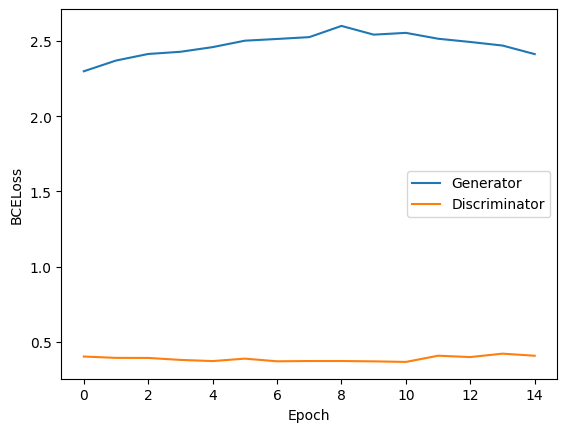

In [171]:
plt.plot(g_losses, label = 'Generator')
plt.plot(d_losses, label = 'Discriminator')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('BCELoss')

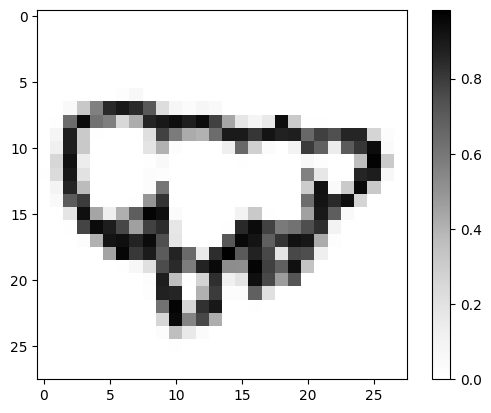

In [194]:
output = generator(random_noise_generator(1, 100).to(device))
plotdata(output.cpu().detach())

# Train a GAN on the MNIST dataset

To get the data:

In [ ]:
import torchvision.datasets as datasets
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
len(mnist_trainset)

60000

You can look at some images and then try to build a DCGAN to generate digits.
